In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np # this is the only math library, you are allowed to import!!
from math import atan, sin, cos, sqrt, acos

In [2]:
corners = [(1,1,1), (1,1, -1), (1, -1, 1), (1, -1, -1), (-1, 1, 1), (-1, 1, -1), (-1, -1, 1), (-1, -1, -1)]
# set corner points

In [3]:
# get distance between point d1 and point d2
def get_dist(d1, d2):
    return sqrt((d1[0]-d2[0])*(d1[0]-d2[0]) + (d1[1]-d2[1])*(d1[1]-d2[1]) + (d1[2]-d2[2])*(d1[2]-d2[2]))

In [4]:
edges = []
nedges = 0
# get egdes by doing not overlap edges
for corner in range(len(corners)):
    for i in range(corner):
        if  get_dist(corners[i], corners[corner]) == 2:
            edges.append((i, corner))
    
print(edges)

[(0, 1), (0, 2), (1, 3), (2, 3), (0, 4), (1, 5), (4, 5), (2, 6), (4, 6), (3, 7), (5, 7), (6, 7)]


In [5]:
# to show 3d coordinates
def show_3d(vertices, edges):
    fig = plt.figure(figsize=(5,5))
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
            [p1[1], p2[1]],
            [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

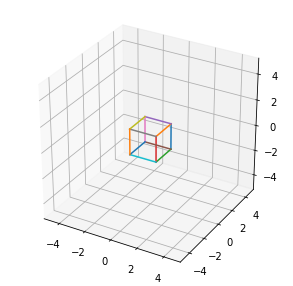

In [6]:
show_3d(corners, edges)

In [7]:
# to get norm
def get_norm (v):
    return sqrt(v[0]*v[0] + v[1]*v[1] + v[2]*v[2])

In [8]:
# rotation matrix
def rot_mat(U, th):

    c = cos(th)
    s = sin(th)
    # get length of U vector
    norm = get_norm(U)
    # U length should be 1, so get length and all elements is devied by the length 
    U = (U[0]/norm, U[1]/norm, U[2]/norm)
    ux = U[0]
    uy = U[1]
    uz = U[2]
    R = [[c+ux*ux*(1-c),    ux*uy*(1-c)-uz*s, ux*uz*(1-c)+uy*s, 0],
         [uy*ux*(1-c)+uz*s, c+uy*uy*(1-c),    uy*uz*(1-c)-ux*s, 0],
         [uz*ux*(1-c)-uy*s, uz*uy*(1-c)+ux*s, c+uz*uz*(1-c),    0],
         [0,                0,                0,                1]]
    return np.array(R)

In [9]:
# translation matrix
def trans_mat(position):
    x = position[0]
    y = position[1]
    z = position[2]
    T = [[1, 0, 0, -x],
         [0, 1, 0, -y],
         [0, 0, 1, -z],
         [0, 0, 0, 1]]
    return np.array(T)

In [10]:
def get_extrinsic_matrix(position,orientation):
    x_ax = [1, 0, 0]
    y_ax = [0, 1, 0]
    z_ax = [0, 0, 1]

    rot_x = rot_mat(x_ax, atan(orientation[0])) # rotate x_axis according to orientation
    rot_y = rot_mat(y_ax, atan(orientation[1])) # rotate y_axis according to orientation
    rot_z = rot_mat(z_ax, atan(orientation[2])) # rotate z_axis according to orientation
    trans = trans_mat(position) # translate according to position

    dot_xy = np.dot(rot_y, rot_x) # dot product Y*X
    dot_xyz = np.dot(rot_z, dot_xy) # dot product Z*Y*X
    dot_xyzt = np.dot(trans, dot_xyz) # dot product T*Z*Y*X
    # so we protect the order that you want
    return np.array(dot_xyzt)

In [11]:
# change points into homogeneous coordinates because we should operate dot_product 4x4 extrinsic matrix 
def to_homogeneous(points):
    to_hom_pt = []
    for pt in points:
        to_hom_pt.append([pt[0], pt[1], pt[2], 1])
    return to_hom_pt

In [12]:
# change homogeneous coordinates into x,y,z
def from_homogeneous(points): # corners
    from_hom_pt = []
    for pt in points:
        from_hom_pt.append([pt[0]/pt[3], pt[1]/pt[3], pt[2]/pt[3]])
    return from_hom_pt

In [13]:
# given camera position and camera orientation
camera_position = [0, 0, -3]
camera_orientation = [0, 0.1, 0]

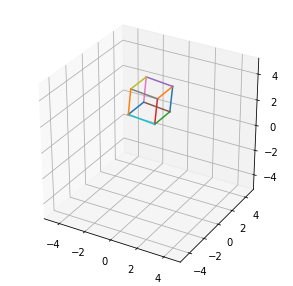

In [14]:
# get extrinsic matrix using camera extrinsic parameters
ex_mat = get_extrinsic_matrix(camera_position, camera_orientation)

# change corners to homogeneous coordinates
hom_corners = to_homogeneous(corners)

# get rotated corners by multiplying extrinsic matrix ( dot_product )
rot_corners = []
for corner in hom_corners:
    rot_corners.append(np.dot(ex_mat, corner))

# remove the last row to remain useful coordinates (x,y,z)
rot_corners = from_homogeneous(rot_corners)

# draw rotated matrix
show_3d(rot_corners, edges)

In [15]:
def get_intrinsic_matrix(f, s):
    sx = s[0]
    sy = s[1]
    K = [[f, 0, sx],
        [0,  f, sy],
        [0,  0, 1]]
    return K

In [16]:
def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
               [p1[1], p2[1]])
    ax.set_xlim(-3, size[0])
    ax.set_ylim(-3, size[1])
    plt.show()

In [17]:
f = 0.55
s = (0.5, 0.5)

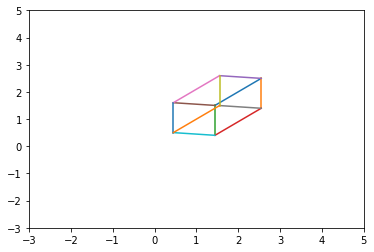

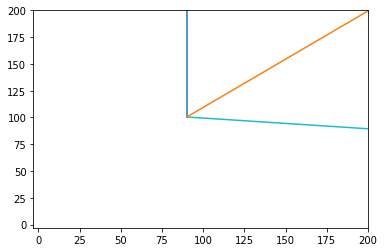

In [18]:
# get intrinsic matrix
in_mat = get_intrinsic_matrix(f, s)

# achieve projection corners by multiplying instrinsic matrix (dot_product)
proj_cns = []
for corner in rot_corners:
    proj_cns.append(np.dot(in_mat, corner))

# show 2d
show_2d(proj_cns, edges, (5,5))

# We multiply all points by 200 and show_2d
proj_cns = 200*np.array(proj_cns)
show_2d(proj_cns, edges, (200,200))

In [19]:
############################################
# BONUS #
############################################

n = 20  # polygon number
pi = 3.1415926535 # get PI
r = 2  # radius
d = 2  # half length of height

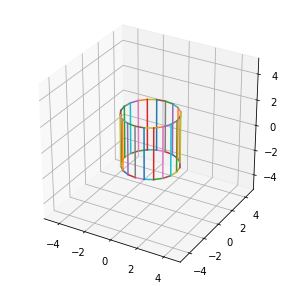

In [20]:
corners = []
# get corners using cosine and sine
# x = r*cos(th), y = r*sin(th), 
# z = d* (-1) power 0 or 1 --> we want to make the center of tube is 0,0,0
# th is angle devided by 2*pi/n * idx
for k in range(2):
    for i in range(n):
        th = 2 * pi / n * i
        x = r * cos(th)
        y = r * sin(th)
        z = d * np.power(-1,k)

        corners.append([x, y, z])
        
# get edges
edges = []
nedges = 0
for i in range(n):
    edges.append((i, (i+1)%n))
    edges.append((n+i, n+(i+1)%n))
    edges.append((i, n+i))
show_3d(corners, edges)

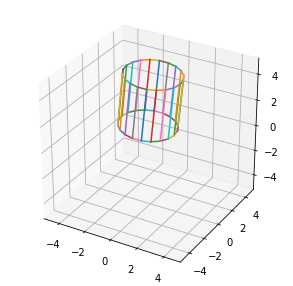

In [21]:
# rotate and translate
hom_corners = to_homogeneous(corners)
rot_corners = []
for corner in hom_corners:
    rot_corners.append(np.dot(ex_mat, corner))
rot_corners = from_homogeneous(rot_corners)
show_3d(rot_corners, edges)

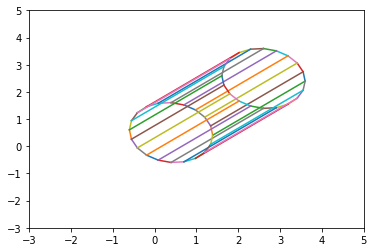

In [22]:
# projection to 2d
proj_cns = []
for corner in rot_corners:
    proj_cns.append(np.dot(in_mat, corner))
    
show_2d(proj_cns, edges, (5,5))